In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
pd.set_option('display.max_columns',None)



from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly

sns.set(style='whitegrid')
plt.rcParams['figure.figsize']=(15,5)
%config InlineBackend.figure_format = 'png'
%matplotlib inline

Грузим чеки 

In [3]:

df_checks_short = pd.read_pickle("./df_checks_short.pkl")

In [4]:
df_checks_short

,CheckUID,id_tt_cl,id_tov_cl,Quantity,week,BaseSum,hour
0,32C04617-1DA6-EC11-9064-005056A7A8DF,16061,25528,1.0,11,422.73,20
1,7CC04B95-79AA-EC11-9064-005056A7A8DF,11846,1609,2.0,12,67.62,10
2,7BC04CF0-8AA6-EC11-9064-005056A7A8DF,11160,49220,1.0,11,124.17,10
3,75C04F15-4C9A-EC11-9064-005056A7A8DF,14258,55220,1.0,9,69.09,19
4,54C0631E-D2AD-EC11-9064-005056A7A8DF,12853,32931,1.0,12,49.09,16
...,...,...,...,...,...,...,...
5497763,85EDD507-7AF5-EC11-9064-005056A7A8DF,12132,23237,1.0,25,0.83,20
5497764,C74F3169-E9E8-EC11-9064-005056A7A8DF,12132,23237,1.0,23,0.83,21
5497765,13299B7C-6FE3-EC11-9064-005056A7A8DF,12192,23237,4.0,22,3.00,21
5497766,5D2B2CB6-F6E4-EC11-9064-005056A7A8DF,12132,23237,2.0,22,1.62,20


Грузим Магазины

In [5]:
df_shops = pd.read_excel('./Data_ALL/Shops ZAO SVAO.xlsx')

In [6]:
df_shops.head()

,id_tt,adress,Hours,Shirota,Dolgota,ploshad,Район,shtat,qty_kassa,qty_kassa_so,format,Region,Start_date
0,10780.0,"Москва Осенний бульвар, д. 12, корп. 6",с 7-00 до 23-30,55.758341,37.413949,111.0,Крылатское,9.0,9.0,3.0,ВкусВилл,ZAO,2014-11-27
1,10786.0,"Москва проспект Вернадского, д. 39",с 8-00 до 22-00,55.675544,37.505894,210.0,Проспект Вернадского,5.0,8.0,1.0,ВкусВилл,ZAO,2014-12-26
2,10864.0,"Москва проспект Мира, д. 116",будни с 8-00 до 22-00; вых. с 9-00 до 22-00,55.808868,37.638011,113.4,Алексеевский,4.0,6.0,2.0,ВкусВилл,SVAO,2015-03-24
3,10904.0,"Москва ул. 26 Бакинских Комиссаров, д. 8, корп. 2",с 9-00 до 22-00,55.659170,37.491359,114.5,Тропарево-Никулино,3.0,5.0,1.0,ВкусВилл,ZAO,2015-05-15
4,11103.0,"Москва Можайское шоссе, д. 28",с 8-00 до 22-00,55.720249,37.421364,155.4,Можайский,5.0,6.0,1.0,ВкусВилл,ZAO,2015-12-01


In [7]:
medium = 120
big = 163

print('Small', df_shops[df_shops['ploshad'] <= medium].shape[0])

print('Medium',df_shops[(df_shops['ploshad'] > medium) & (df_shops['ploshad'] <= big)].shape[0])

print('Big', df_shops[df_shops['ploshad'] > big].shape[0])

Small 51
Medium 55
Big 53


Делим магазины на размеры

In [8]:
conditions_s = [
    (df_shops['ploshad'] <= medium),
    (df_shops['ploshad'] > medium) & (df_shops['ploshad'] <= big),
    (df_shops['ploshad'] > big) 
]
values_s = ['S','M','L']

df_shops['size'] = np.select(conditions_s,values_s)

In [9]:
l_shops_S = df_shops['id_tt'][df_shops['size'] == 'S'].to_list()
l_shops_M = df_shops['id_tt'][df_shops['size'] == 'M'].to_list()
l_shops_L = df_shops['id_tt'][df_shops['size'] == 'L'].to_list()

Создаем Pivot таблицу с продажами

In [10]:
df_pivot_table_S = df_checks_short[df_checks_short['id_tt_cl'].isin(l_shops_S)]\
    .pivot_table(columns=['week'], index=['id_tt_cl'], values = ['BaseSum'])\
    .pct_change(axis=1).copy()

df_pivot_table_M = df_checks_short[df_checks_short['id_tt_cl'].isin(l_shops_M)]\
    .pivot_table(columns=['week'], index=['id_tt_cl'], values = ['BaseSum'])\
    .pct_change(axis=1).copy()

df_pivot_table_L = df_checks_short[df_checks_short['id_tt_cl'].isin(l_shops_L)]\
    .pivot_table(columns=['week'], index=['id_tt_cl'], values = ['BaseSum'])\
    .pct_change(axis=1).copy()

Выделяем плохие и хорошие магазины на основе изменения продаж в этом магазине на неделе по сравнению с общей динамикой

In [11]:
df_week_diff_S = df_pivot_table_S - df_pivot_table_S.median()
df_week_diff_M = df_pivot_table_M - df_pivot_table_M.median()
df_week_diff_L = df_pivot_table_L - df_pivot_table_L.median()

In [12]:
df_week_diff_cum_S = (df_week_diff_S - df_week_diff_S.median()).cumsum(axis=1)
df_week_diff_cum_M = (df_week_diff_M - df_week_diff_M.median()).cumsum(axis=1)
df_week_diff_cum_L = (df_week_diff_L - df_week_diff_L.median()).cumsum(axis=1)

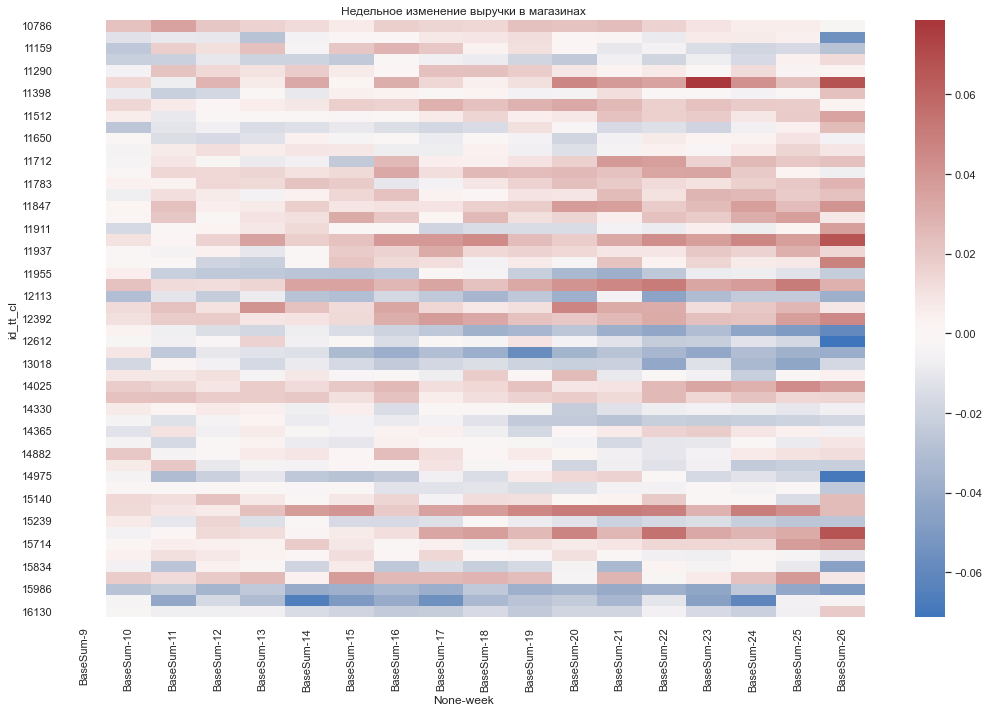

In [13]:
plt.figure(figsize=(15, 10))
week_dif =sns.heatmap(df_week_diff_cum_L, cmap='vlag',center = 0)
plt.title('Недельное изменение выручки в магазинах');
fig = week_dif.get_figure()
fig.tight_layout()
fig.savefig('week_dif.jpeg')

Копируем итоговое Качество магазов в Series

In [14]:
m = 20
list_bad_S = df_week_diff_cum_S.iloc[:,-1].nsmallest(n = m).index.to_list()
list_bad_M = df_week_diff_cum_M.iloc[:,-1].nsmallest(n = m).index.to_list()
list_bad_L = df_week_diff_cum_L.iloc[:,-1].nsmallest(n = m).index.to_list()
list_good_S = df_week_diff_cum_S.iloc[:,-1].nlargest(n = m).index.to_list()
list_good_M = df_week_diff_cum_M.iloc[:,-1].nlargest(n = m).index.to_list()
list_good_L = df_week_diff_cum_L.iloc[:,-1].nlargest(n = m).index.to_list()

In [26]:
df_week_diff_cum_S.iloc[:,-1]

id_tt_cl
10780    0.026183
10864   -0.017693
10904   -0.047143
11127   -0.002660
11309    0.021417
11421   -0.021530
11457    0.020643
11600    0.006431
11616   -0.037244
11658    0.063952
11697    0.005903
11698    0.028536
11723    0.012770
11732    0.008230
11750    0.073528
11875   -0.020966
11912    0.047695
11956    0.036003
12004   -0.031823
12072   -0.037491
12192   -0.026047
12261    0.006677
12285   -0.017828
12296    0.000621
12335   -0.008895
12337    0.002863
12348   -0.009308
12468    0.013730
12518   -0.020667
12533   -0.019794
12611    0.038843
12689   -0.006536
12712   -0.018070
12821    0.011667
12834    0.024148
12859    0.032015
12871    0.022192
12938   -0.016964
13012   -0.008578
13168    0.023079
13185   -0.017371
13429    0.001251
13623    0.001333
13767    0.017904
13779   -0.018694
13968    0.002042
14125    0.008053
14184   -0.045141
14537    0.020559
14859   -0.020776
14966    0.012168
Name: (BaseSum, 26), dtype: float64

Размечаем таблицу с магазинами по качеству магазинов

In [15]:
conditions_s = [
    (df_shops['id_tt'].isin(list_bad_L)),
    (df_shops['id_tt'].isin(list_bad_M)),
    (df_shops['id_tt'].isin(list_bad_S)),
    (df_shops['id_tt'].isin(list_good_S)),
    (df_shops['id_tt'].isin(list_good_M)),
    (df_shops['id_tt'].isin(list_good_L)),
    (df_shops['size'] == 'S'),
    (df_shops['size'] == 'M'),
    (df_shops['size'] == 'L')
]
values_s = [-3,-2,-1,1,2,3,10,20,30]

df_shops['quality'] = np.select(conditions_s,values_s, default=0)

In [16]:
df_shops['id_tt'] = df_shops['id_tt'].astype('int')

In [17]:
df_shops = df_shops.set_index('id_tt')

In [19]:
df_shops.to_excel("./df_shops.xlsx")

In [20]:
df_shops.to_pickle("./df_shops.pkl")

In [21]:
lis_shops = df_shops.index.to_list()

In [22]:
df_checks_short.shape[0]

45915056

In [23]:
df_checks_short.shape[0]

45915056

In [24]:
#Убираем из чеков магазины ко оторым у нас нет данных 
df_checks_short = df_checks_short[df_checks_short['id_tt_cl'].isin(lis_shops)]

In [25]:
df_checks_short.to_pickle("./df_checks_short.pkl")